In [1]:
from glob import glob
import re
import string
import funcy as fp
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt

In [40]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD

In [10]:
winterfell = pickle.load( open( "./Data/winterfell_1.pkl", "rb" ) )

In [11]:
winterfell = winterfell.dropna()

In [12]:
winterfell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29926 entries, 17135 to 47562
Data columns (total 2 columns):
Publish Date    29926 non-null datetime64[ns]
clean           29926 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 701.4+ KB


In [13]:
text = winterfell['clean']

In [14]:
import spacy
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nborders/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [17]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nborders/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
stop_words = ['would', 'could', 'might', 'season', 'think', 'one', 'watch', 'episode', 'something', 'theory', 'maybe',
             'scene', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'even']

In [51]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [52]:
import random
text_data = []
for line in text:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        text_data.append(tokens)

In [53]:
text_data = [x for x in text_data if x != []]

In [54]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

In [55]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [24]:
#pickle.dump(corpus, open('corpus_winterfell.pkl', 'wb'))
#dictionary.save('dictionary_winterfell.gensim')

In [67]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=20)
#ldamodel.save('model4_winterfell.gensim')

/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)


In [68]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.023*"night" + 0.018*"cersei" + 0.009*"island" + 0.008*"people" + 0.008*"power" + 0.008*"since" + 0.007*"queen" + 0.007*"character" + 0.007*"dragon" + 0.006*"winterfell"')
(1, '0.018*"jamie" + 0.017*"throne" + 0.008*"dragon" + 0.007*"going" + 0.007*"sansa" + 0.007*"moment" + 0.007*"golden" + 0.007*"company" + 0.007*"thing" + 0.007*"night"')
(2, '0.019*"night" + 0.019*"wheel" + 0.014*"jamie" + 0.012*"little" + 0.009*"brother" + 0.008*"jaime" + 0.008*"rhaegar" + 0.008*"reunion" + 0.008*"chaos" + 0.007*"try"')
(3, '0.019*"people" + 0.012*"suppose" + 0.010*"sansa" + 0.009*"daenerys" + 0.009*"someone" + 0.008*"stark" + 0.007*"nobody" + 0.007*"story" + 0.007*"right" + 0.006*"actor"')
(4, '0.022*"night" + 0.015*"dragon" + 0.010*"throne" + 0.009*"character" + 0.008*"walker" + 0.008*"white" + 0.008*"people" + 0.007*"first" + 0.006*"stark" + 0.006*"base"')


In [ ]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [69]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [28]:
corpus_cloud = ' '.join(winterfell['clean'])

In [65]:
STOPWORDS.update(['would', 'could', 'might', 'season', 'think', 'one', 'watch', 'episode', 'something', 'theory', 'maybe',
             'scene', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'even'])

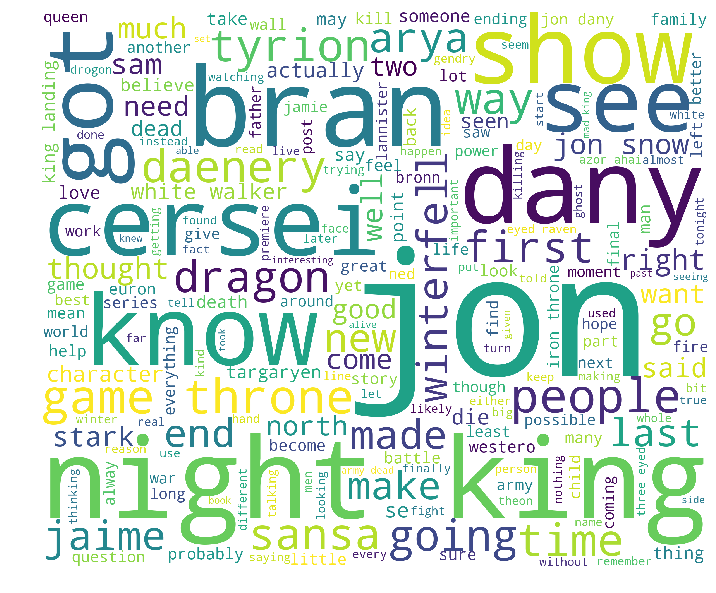

In [66]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=2400,height=2000).generate(corpus_cloud)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()